In [2]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [3]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
from qutip import propagator,floquet_modes,Qobj,Options,basis
from scipy.optimize import linear_sum_assignment
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
    
    return sorted_eigenvalues, sorted_eigenvectors
def zero_corresponding_elements(A, B):
    # Ensure A and B have the same shape
    if A.shape != B.shape:
        raise ValueError("Matrices A and B must have the same shape")
    
    # Create a copy of B to modify and return
    B_new = B.copy()
    
    # Set elements in B_new to zero where A is non-zero
    B_new[A != 0] = 0
    
    return B_new
def one_corresponding_elements(A, B):
    # Ensure A and B have the same shape
    if A.shape != B.shape:
        raise ValueError("Matrices A and B must have the same shape")
    
    # Create a copy of B to modify and return
    B_new = B.copy()
    
    # Set elements in B_new to zero where A is non-zero
    B_new[A == 0] = 0
    
    return B_new

In [88]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    flux =0.4325
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 6
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()


    #cavity1 parameters
    omega_c1 = 4.5*2*np.pi
    g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 3
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 =  8.5*2*np.pi
    g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
    dimc2 = 3
    cavity2 = Cavity(omega_c2,g_int2,dimc2)

    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy,U = np.linalg.eigh(H)
    energy,U = sort_eigenpairs(energy, U)
    Ud = U.transpose().conjugate()
    H = Ud@H@U
    Hc = Ud@Hc@U
    c = annihilation(dimc1)
    cd = creation(dimc1)
#     Hgbs = np.kron(np.kron(np.identity(dims),c),cd)+np.kron(np.kron(np.identity(dims),cd),c)
#     Hc = zero_corresponding_elements(Hgbs, Hc)
    index1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    index2 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    H0 = H
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, index1), basis(total_dim, index2)]
    
    
    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    omegac1p = f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, omegac1p , omega/2/np.pi)
    omegac1p = omegac1p + k *omega/2/np.pi
    omegac2p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, omegac2p, omega/2/np.pi)
    omegac2p = omegac2p + k *omega/2/np.pi
    diff = omegac2p - omegac1p
    return diff

In [89]:
energy_diff(0,10)

4.010478690767836

In [90]:
import scipy
def fit_avoided_crossing(energy_diff,upthre,lothre):
    print(omegas,detuning)
    # define the cost function to fit the avoided crossing
    def cost_func(parameters):
        g = parameters[0]   # beam splitter rate 
        a = parameters[1]   # energy difference between two modes, excluding effects from avoided crossings 
        res = 0
        for i in range(len(omegas)):
            # sometimes it is helpful to select the part of data to fit with 
            # if omega_list[i]/(2*np.pi)<3.95 or omega_list[i]/(2*np.pi) > 3.96:
#             if omegas[i]<0.279:
                if np.abs(energy_diff[i]>upthre) or np.abs(energy_diff[i]<lothre):
                    continue
                delta =   detuning - omegas[i]
                res += np.abs(energy_diff[i] - (a+ np.sign(delta) * np.sqrt(4*g**2 + (delta)**2) - delta ) )**2 
        return res

    # boundaries of the fitting parameters 
    bb = scipy.optimize.Bounds(np.array([0.01e-4, detuning-1e-1,]), np.array([1e-3, detuning+1e-1,]))
    
    # initial guess 
    x0 = np.array([1e-5, detuning])
    
    res = scipy.optimize.minimize(cost_func, x0, bounds=bb, method='Powell', tol=1e-30)
    print(res)
    # store fitted beam splitter rate, unit in MHz
    g = res.x[0]   
    a = res.x[1]
    return g, a,
def displacement(A):
    flux =0.4325
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 200
    N = 3
    dims = 8
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()


    #cavity1 parameters
    omega_c1 = 4.5*2*np.pi
    g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 =  8.5*2*np.pi
    g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)

    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)
    eta = A/2/snail.phi_zpf/2/(snail.omegas-4.0104780296943225*2*np.pi)
    return eta,6*eta*snail.g3/2/np.pi*cavity2.g_int * snail.c2**0.25/(snail.omegas-omega_c2)*cavity1.g_int * snail.c2**0.25/(snail.omegas-omega_c1)

In [91]:
A_values = np.linspace(1.4,1.5,5)*2*np.pi
gs1 = []
A = 1.3*2*np.pi
# for A in A_values:
detuning = 4.0104780296943225*2*np.pi
omegas = np.linspace(detuning-0.3e-3*2*np.pi, detuning+0.3e-3*2*np.pi, 30)
results = Parallel(n_jobs=30)(delayed(energy_diff)(A, omega) for omega in omegas)
index_of_min = np.argmin(results)
index_of_max = np.argmax(results)
detuning = (omegas[index_of_min]+omegas[index_of_max])/2/2/np.pi
omegas = omegas/2/np.pi
g,a = fit_avoided_crossing(results,4.02,4)
gs1.append(g)


[4.01017803 4.01019872 4.01021941 4.0102401  4.01026079 4.01028148
 4.01030217 4.01032286 4.01034355 4.01036424 4.01038493 4.01040562
 4.01042631 4.010447   4.01046768 4.01048837 4.01050906 4.01052975
 4.01055044 4.01057113 4.01059182 4.01061251 4.0106332  4.01065389
 4.01067458 4.01069527 4.01071596 4.01073665 4.01075734 4.01077803] 4.010271133142599
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 8.26878981397673e-12
       x: [ 3.053e-04  4.010e+00]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [ 1.112e-07  1.313e-07]]
    nfev: 124


In [38]:
disp = []
rate = []
for A in A_values:
    disp.append(displacement(A)[0])
    rate.append(displacement(A)[1])

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

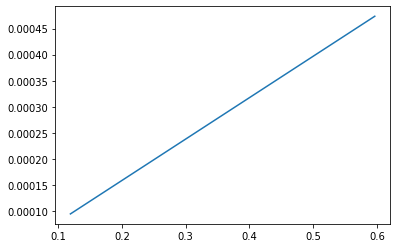

In [39]:
plt.plot(disp,rate)
plt.plot(disp,gs1)

In [51]:
(gs1[-1]-gs1[0])/(A_values[-1]-A_values[0])*2*np.pi

0.0

In [52]:
(A_values[-1]-A_values[0])

7.5398223686155035

In [53]:
(gs1[-1]-gs1[0])

0.0

In [54]:
# plt.plot(disp,result)
# plt.plot(disp,gs)

/tmp/ipykernel_834620/2704417918.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(omegas, results,'.', marker='o',)


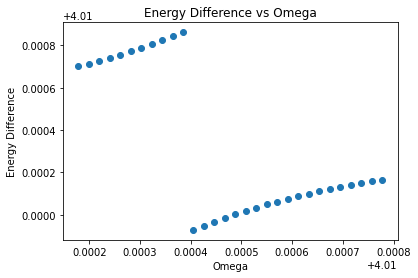

In [55]:
plt.plot(omegas, results,'.', marker='o',)
# plt.ylim(1.20,1.205)
plt.xlabel('Omega')
plt.ylabel('Energy Difference')
plt.title('Energy Difference vs Omega')
# plt.ylim(4,4.02)
plt.show()


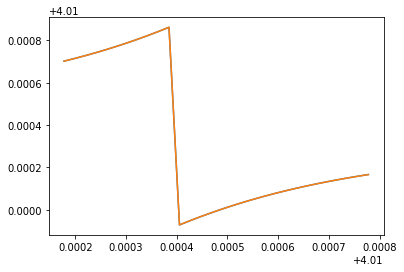

In [56]:
delta = -omegas + (detuning) *np.ones(len(omegas))
plt.plot(omegas,(a+ np.sign(delta) * np.sqrt(4*g**2 + (delta)**2) - delta ))
plt.plot(omegas,results)
# plt.ylim(4,4.02)
# plt.ylim(1.204,1.206)

In [684]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff2(A,omega):
    flux =0.406400
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 8
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()


    #cavity1 parameters
    omega_c1 = 4.5*2*np.pi
    g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 =  8.5*2*np.pi
    g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)

    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy,U = np.linalg.eigh(H)
    energy,U = sort_eigenpairs(energy, U)
    Ud = U.transpose().conjugate()
    H = Ud@H@U
    Hc = Ud@Hc@U
    c = annihilation(dimc1)
    cd = creation(dimc1)
    s = annihilation(dims)
    sd = creation(dims)
#     Hgbs = np.kron(np.kron(np.identity(dims),c),cd)+np.kron(np.kron(np.identity(dims),cd),c)
    Hgbs = np.kron(np.kron(np.ones((dims,dims)),c),cd)+np.kron(np.kron(np.ones((dims,dims)),cd),c)
    Hgbs += np.kron(np.kron(s+sd,np.identity(dimc1)),np.identity(dimc2))+np.kron(np.kron(s+sd,np.identity(dimc1)),np.identity(dimc2))
#     Hgbs += np.kron(np.kron(s+sd,c),cd)+np.kron(np.kron(s+sd,cd),c)
    Hc = one_corresponding_elements(Hgbs, Hc)
    index1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    index2 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    H0 = H
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, index1), basis(total_dim, index2)]
    
    
    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    omegac1p = f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, omegac1p , omega/2/np.pi)
    omegac1p = omegac1p + k *omega/2/np.pi
    omegac2p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, omegac2p, omega/2/np.pi)
    omegac2p = omegac2p + k *omega/2/np.pi
    diff = omegac2p - omegac1p
    return diff

In [598]:
gs = []
# A = 5*2*np.pi
for A in A_values:
    detuning =  4.0104780296943225*2*np.pi
    omegas = np.linspace(detuning-0.3e-3*2*np.pi, detuning+0.3e-3*2*np.pi, 30)
    results = Parallel(n_jobs=15)(delayed(energy_diff2)(A, omega) for omega in omegas)
    index_of_min = np.argmin(results)
    index_of_max = np.argmax(results)
    detuning = (omegas[index_of_min]+omegas[index_of_max])/2/2/np.pi
    omegas = omegas/2/np.pi
    g,a = fit_avoided_crossing(results,100,0)
    gs.append(g)


[4.01017803 4.01019872 4.01021941 4.0102401  4.01026079 4.01028148
 4.01030217 4.01032286 4.01034355 4.01036424 4.01038493 4.01040562
 4.01042631 4.010447   4.01046768 4.01048837 4.01050906 4.01052975
 4.01055044 4.01057113 4.01059182 4.01061251 4.0106332  4.01065389
 4.01067458 4.01069527 4.01071596 4.01073665 4.01075734 4.01077803] 4.010643546935702
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.665328174629876e-12
       x: [ 4.894e-04  4.011e+00]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-4.262e-08  4.320e-08]]
    nfev: 131
[4.01017803 4.01019872 4.01021941 4.0102401  4.01026079 4.01028148
 4.01030217 4.01032286 4.01034355 4.01036424 4.01038493 4.01040562
 4.01042631 4.010447   4.01046768 4.01048837 4.01050906 4.01052975
 4.01055044 4.01057113 4.01059182 4.01061251 4.0106332  4.01065389
 4.01067458 4.01069527 4.01071596 4.01073665 4.01075734 4.01077803] 4.0104780296943225
 message: Optimization terminated successfully.
 succ

In [599]:
g

1.000000001482578e-06

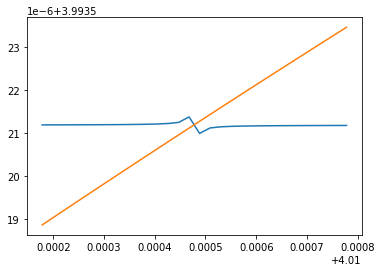

In [600]:
delta = -omegas + (detuning) *np.ones(len(omegas))
plt.plot(omegas,(a+ np.sign(delta) * np.sqrt(4*g**2 + (delta)**2) - delta ))
plt.plot(omegas,results)
# plt.ylim(1.204,1.206)

In [601]:
A_values = np.linspace(2,5,4)*2*np.pi
A_values/2/np.pi

array([2., 3., 4., 5.])

In [602]:
gs

[0.0004894062968206518,
 1.000000012585842e-06,
 4.191753117379518e-05,
 1.000000001482578e-06]

ValueError: x and y must have same first dimension, but have shapes (6,) and (4,)

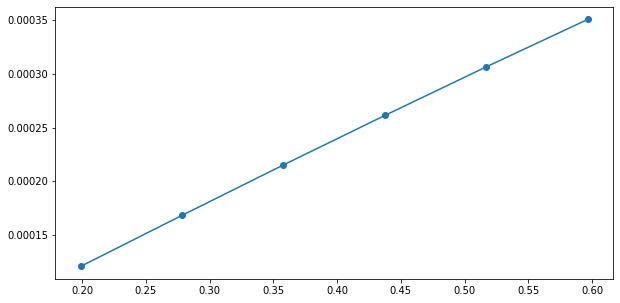

In [603]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(disp, gs1, marker='o', label='Previous Combined List')
plt.plot(disp, gs, marker='x', label='New Combined List')
plt.title('Comparison of A values vs. Combined List Values')
plt.xlabel('A values (0.5, 1, ..., 5)')
plt.ylabel('List Values')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
[1.636219360849445e-05,
 3.2712339330490106e-05,
 4.9126353340123596e-05,
 6.563670428038323e-05,
 8.230487786455534e-05,
 9.930732033913214e-05]
[0.00011609274532256626,
 0.00011412036264886066,
 0.0001237011916561157,
 0.00013808842776595829]
